In [1]:
import numpy as np
import time
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage import restoration
from numpy.fft import fft2, ifft2, fftshift
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.ndimage import gaussian_filter

import edi as edi_py
import mtf as mtf_py
import hpo as hpo_py
import drizzle as drizzle_py
import ibp as ibp_py
from subpixel_edges import subpixel_edges

In [2]:
img = np.zeros((8, 8))

subpixel_edges(img, 15, 0, 2)
subpixel_edges(img, 15, 1, 2)
subpixel_edges(img, 15, 2, 2)

In [ ]:
def generate_synthetic_lr_images(img_hr, scale_factor=2):
    img_hr = img_hr.astype(np.float32) / 255.0
    h_hr, w_hr = img_hr.shape[:2]

    h_lr = h_hr // scale_factor
    w_lr = w_hr // scale_factor

    # --- Define Pipeline Parameters ---
    # Recommendation: Sigma should relate to scale factor to simulate realistic PSF.
    # A common approximation is sigma = 0.5 * scale_factor.
    blur_sigma = 0.5 * scale_factor
    # Kernel size needs to be odd and cover roughly 3*sigma in each direction.
    blur_ksize = int(np.ceil(blur_sigma * 3) * 2 + 1)

    # Recommendation: Noise level (standard deviation).
    # 0.01 to 0.05 (for 0-1 range image) corresponds to reasonable camera noise.
    noise_std_dev = 0.01 

    lr_images_list = []
    applied_shifts = [(0., 0.), (1., 0.), (0., 1.), (1., 1.)]
    num_frames = 4

    print(f"Generating {num_frames} frames with scale {scale_factor}x...")

    for k in range(num_frames):
        # --- Step 1: Warping matrix (W_K) ---
        dx, dy = applied_shifts[k]

        # Create affine transformation matrix for translation
        M_translation = np.float32([[1, 0, dx], [0, 1, dy]])

        # Apply warp on HR grid.
        # BORDER_REFLECT helps avoid artificial black edges coming into view.
        img_warped = cv2.warpAffine(img_hr, M_translation, (w_hr, h_hr),
                                    borderMode=cv2.BORDER_REFLECT_101)


        # --- Step 2: Blurring matrix (B_K) ---
        # Apply Gaussian blur to simulate optical Point Spread Function (PSF).
        img_blurred = cv2.GaussianBlur(img_warped, (blur_ksize, blur_ksize), blur_sigma)


        # --- Step 3: Decimation matrix (D_K) ---
        # Downsample the image.
        # cv2.INTER_AREA is highly recommended as it mimics sensor pixel integration
        # (averaging area) rather than just picking the nearest neighbor pixel.
        img_decimated = cv2.resize(img_blurred, (w_lr, h_lr), interpolation=cv2.INTER_AREA)


        # --- Step 4: Additive Noise (eta_K) ---
        # Generate Gaussian noise with zero mean.
        noise = np.random.normal(0, noise_std_dev, img_decimated.shape).astype(np.float32)
        img_lr_noisy = img_decimated + noise


        # --- Finalizing output ---
        # Clip values to ensure they stay within valid image range [0.0, 1.0]
        img_lr_final = np.clip(img_lr_noisy, 0.0, 1.0)
        lr_images_list.append((img_lr_final * 255.0).astype(np.uint8))


    print(f"Completed")
    return lr_images_list




def unsharp_mask(img, radius=1.5, amount=1.0):
    blurred = cv2.GaussianBlur(img, (0, 0), radius)
    sharp = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)

def clahe(img, clip_limit=0.5):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    temp = cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2RGB)
    return cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)

def apply_richardson_lucy(image, psf_size=5, iterations=30):
    print(f"PSF restoration (Richardson-Lucy, {iterations} iterations)")
    print("Processing...")
    
    img_float = image.astype(np.float32) / 255.0
    img_float = np.clip(img_float, 0, 1)
    
    psf = np.zeros((psf_size, psf_size))
    sigma = (psf_size - 1) / 4.0
    center = psf_size // 2
    for x in range(psf_size):
        for y in range(psf_size):
            dist = np.sqrt((x-center)**2 + (y-center)**2)
            psf[x, y] = np.exp(-(dist**2) / (2 * sigma**2))
    psf /= psf.sum()
    
    deconvolved = restoration.richardson_lucy(img_float, psf, num_iter=iterations, filter_epsilon=1e-6)
    return np.clip(deconvolved * 255, 0, 255).astype(np.uint8)

def wiener_deconvolution(img, psf_size, K):
    """
    img : blurred image (2D, float32)
    psf : point spread function
    K   : noise-to-signal ratio (e.g. 0.001–0.01)
    """
    img_float = img.astype(np.float32) / 255.

    
    # Gaussian psf
    sigma = (psf_size - 1) / 4.0
    ax = np.arange(-psf_size//2 + 1., psf_size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    psf / psf.sum()
    
    
    # Pad PSF to image size
    psf_pad = np.zeros_like(img)
    ph, pw = psf.shape
    psf_pad[:ph, :pw] = psf
    psf_pad = fftshift(psf_pad)

    deconvolved = restoration.wiener(img_float, psf, balance=K)
    return np.clip(deconvolved * 255, 0, 255).astype(np.uint8)








def calculate_metrics(img1, img2):
    if img1 is None or img2 is None:
        print("Error: Could not load one or both images.")
        return


    if img1.shape != img2.shape:
        print(f"Dimension mismatch: {img1.shape} vs {img2.shape}")
        return

    # Calculate PSNR
    psnr_value = psnr(img1, img2, data_range=255)

    # Calculate SSIM

    if img1.ndim == 2:
        # Grayscale
        ssim_value = ssim(img1, img2, data_range=255)
    else:
        # Color (H, W, C)
        ssim_value = ssim(img1, img2, data_range=255, channel_axis=2)

    return psnr_value, ssim_value






def compute_mtf_at_nyquist(img, filename='test_LR800x800_v5_MTF', quantile_low=0.25, quantile_high=0.75, dpi=100, scale=1):
    start_time = time.time()
    
    # 1. Normalize input image
    img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # 2. Set edge detection parameters
    edge_threshold = 1 / (25 * (np.quantile(img_normalized, quantile_high) - np.quantile(img_normalized, quantile_low)))
    
    # 3. Edge detection
    edges = subpixel_edges(img_normalized, edge_threshold, 1, 1)
    
    # 4. Obtain edge coordinate
    edges_xy = np.array([edges.x, edges.y]).T
    
    # 5. Visualize edges
    # plt.figure(figsize=(img_normalized.shape[1]/5., img_normalized.shape[0]/5.))
    # plt.imshow(img_normalized, cmap="gray", vmin=0., vmax=1.)
    # plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    # plt.scatter(edges.x, edges.y, s=5, marker='.', c='red')
    # plt.tight_layout()
    # plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    # plt.close()
    
    # 6. Calculate MTF
    MTF_at_Nyquist, MTF_50 = mtf_py.MTF.FigureMTF(
        img_normalized, 
        img_normalized, 
        edges_xy, 
        filename, 
        0, 0, 0, 
        scale,
        verbose=True
    )
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"MTF evaluation finished! Elapsed time: {elapsed_time:.2f} seconds")
    
    return MTF_at_Nyquist, MTF_50

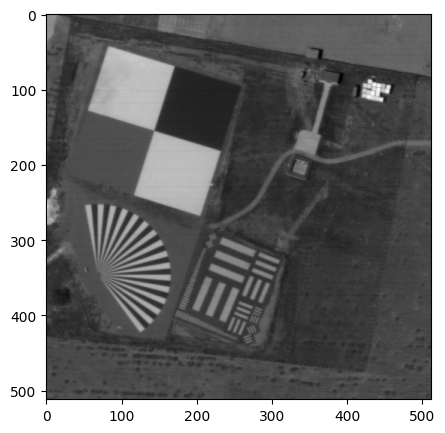

In [4]:
HR = np.load('../HPO dataset/data2/HR.npy')
min_val = np.min(HR)
max_val = np.max(HR)

HR = (HR - min_val) / (max_val - min_val)
HR = np.clip(HR * 255, 0, 255).astype(np.uint8)

H, W = HR.shape

Image.fromarray(HR).save('../HPO dataset/data2/HR.png')

plt.figure(figsize=(5,5))
plt.tick_params(axis='both', which='major', labelsize=10)
plt.imshow(HR, cmap='gray')
plt.show()

In [5]:
LRs = generate_synthetic_lr_images(HR)

LR1, LR2, LR3, LR4 = LRs
h, w = LR1.shape

Image.fromarray(LR1).save('../HPO dataset/data2/LR1.png')
Image.fromarray(LR2).save('../HPO dataset/data2/LR2.png')
Image.fromarray(LR3).save('../HPO dataset/data2/LR3.png')
Image.fromarray(LR4).save('../HPO dataset/data2/LR4.png')

Generating 4 frames with scale 2x...
Completed


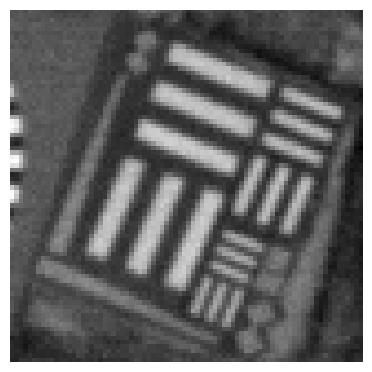

In [6]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(LRs[0][141:221, 80:160], cmap='gray')
plt.show()

In [7]:
t1 = time.time()
s = ibp_py.calculate_shift(LRs[0], LRs, 'ecc')
print(time.time() - t1)
print(s)

Registering images (measuring random shifts) using ECC...
Image 1 Shift: x=0.4843, y=0.0077
Image 2 Shift: x=-0.0015, y=0.4968
Image 3 Shift: x=0.5100, y=0.5001
0.015622138977050781
[[0.0, 0.0], [np.float32(0.4842521), np.float32(0.007700798)], [np.float32(-0.0015266028), np.float32(0.4967668)], [np.float32(0.5100137), np.float32(0.5001182)]]


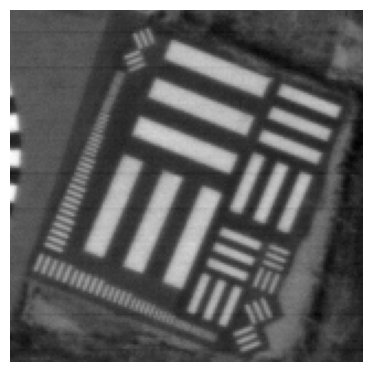

In [8]:
x1, y1 = 80, 140
hr = HR[x1:x1+48, y1:y1+48]

x2, y2 = 283, 161
hr_window = HR[x2:x2+160, y2:y2+160]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(hr_window, cmap='gray')

# ax2 = plt.subplot(1, 2, 2)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.imshow(hr, cmap='gray')

plt.show()

In [9]:
MTF_at_Nyquist_hr, MTF_50_hr = compute_mtf_at_nyquist(hr, filename = f'HR', dpi=100, scale=1)

if MTF_at_Nyquist_hr is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_hr)
    print("MTF_50:", MTF_50_hr)


MTF evaluation finished! Elapsed time: 1.21 seconds
MTF_at_Nyquist: 4.1717256775589355
MTF_50: 0.140810456101759


0.0006191730499267578


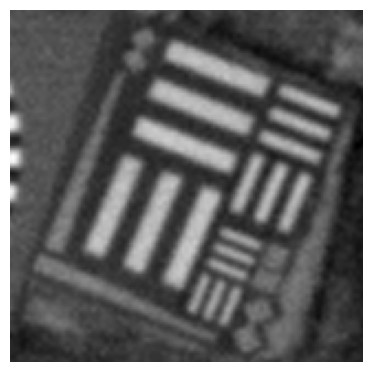

In [10]:
t1 = time.time()
SR_bicubic = cv2.resize(LR1, (w*2, h*2), interpolation=cv2.INTER_CUBIC)
# SR_bicubic = wiener_deconvolution(SR_bicubic, psf_size=3, K=0.001)
# SR_bicubic = apply_richardson_lucy(SR_bicubic, psf_size=3, iterations=30)
# SR_bicubic = clahe(SR_bicubic, clip_limit=0.5)
# SR_bicubic = unsharp_mask(SR_bicubic, radius=1.0, amount=1.2)
p_time = time.time() - t1
print(p_time)

Image.fromarray(SR_bicubic).save('../HPO dataset/data2/SR_bicubic.png')


sr_bicubic = SR_bicubic[x1:x1+48, y1:y1+48]
sr_bicubic_window = SR_bicubic[x2:x2+160, y2:y2+160]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_bicubic_window, cmap='gray')

# ax2 = plt.subplot(1, 2, 2)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.imshow(sr_bicubic, cmap='gray')

plt.show()




In [11]:
MTF_at_Nyquist_sr_bicubic, MTF_50_sr_bicubic = compute_mtf_at_nyquist(sr_bicubic, filename = f'SR_BICUBIC2', scale=1, dpi=100)

if MTF_at_Nyquist_sr_bicubic is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_bicubic)
    print("MTF_50:", MTF_50_sr_bicubic)

print() 
metrics = calculate_metrics(HR[4:-4, 4:-4], SR_bicubic[4:-4, 4:-4])
if metrics:
    print(f"PSNR: {metrics[0]:.2f} dB")
    print(f"SSIM: {metrics[1]:.4f}")

MTF evaluation finished! Elapsed time: 1.06 seconds
MTF_at_Nyquist: 0.06801523926132406
MTF_50: 0.09560213984150617

PSNR: 34.76 dB
SSIM: 0.8970


0.0


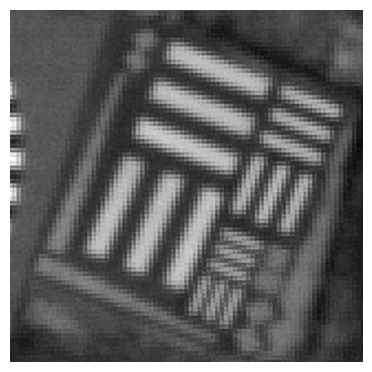

In [12]:
t1 = time.time()
SR_shuffle = hpo_py.HPO_shuffle(LRs).astype(np.uint8)
# SR_shuffle = apply_richardson_lucy(SR_shuffle, psf_size=5, iterations=30)
# SR_shuffle = unsharp_mask(SR_shuffle, radius=1.0, amount=1.2)
p_time = time.time() - t1
print(p_time)

Image.fromarray(SR_shuffle).save('../HPO dataset/data2/SR_shuffle.png')

sr_shuffle = SR_shuffle[x1:x1+48, y1:y1+48]
sr_shuffle_window = SR_shuffle[x2:x2+160, y2:y2+160]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_shuffle_window, cmap='gray')

# ax2 = plt.subplot(1, 2, 2)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.imshow(sr_shuffle, cmap='gray')

plt.show()

In [13]:
MTF_at_Nyquist_sr_shuffle, MTF_50_sr_shuffle = compute_mtf_at_nyquist(sr_shuffle, filename = f'SR_SHUFFLE2', scale=1, dpi=100)

if MTF_at_Nyquist_sr_shuffle is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_shuffle)
    print("MTF_50:", MTF_50_sr_shuffle)


print() 
metrics = calculate_metrics(HR[4:-4, 4:-4], SR_shuffle[4:-4, 4:-4])
if metrics:
    print(f"PSNR: {metrics[0]:.2f} dB")
    print(f"SSIM: {metrics[1]:.4f}")

MTF evaluation finished! Elapsed time: 1.09 seconds
MTF_at_Nyquist: 0.01135842019093641
MTF_50: 0.08122115246717514

PSNR: 28.74 dB
SSIM: 0.7902


Registering images (measuring random shifts) using ECC...
Image 1 Shift: x=0.4843, y=0.0077
Image 2 Shift: x=-0.0015, y=0.4968
Image 3 Shift: x=0.5100, y=0.5001
Accumulating/Splatting pixels...
0.01900029182434082


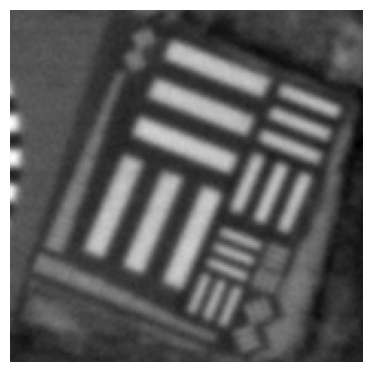

In [14]:
t1 = time.time()
computed_homographies = drizzle_py.register_images(LR1, LRs, 'ecc')
SR_drizzle = drizzle_py.super_resolve_drizzle(LRs, computed_homographies, scale=2)
# SR_drizzle = wiener_deconvolution(SR_drizzle, psf_size=3, K=0.001)
# SR_drizzle = apply_richardson_lucy(SR_drizzle, psf_size=3, iterations=30)
# SR_drizzle = clahe(SR_drizzle, clip_limit=0.5)
# SR_drizzle = unsharp_mask(SR_drizzle, radius=1.0, amount=1.2)

p_time = time.time() - t1
print(p_time)

Image.fromarray(SR_drizzle).save('../HPO dataset/data2/SR_drizzle.png')

sr_drizzle = SR_drizzle[x1:x1+48, y1:y1+48]
sr_drizzle_window = SR_drizzle[x2:x2+160, y2:y2+160]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_drizzle_window, cmap='gray')

# ax2 = plt.subplot(1, 2, 2)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.imshow(sr_drizzle, cmap='gray')

plt.show()

In [15]:
MTF_at_Nyquist_sr_drizzle, MTF_50_sr_drizzle = compute_mtf_at_nyquist(sr_drizzle, filename = f'SR_DRIZZLE2', scale=1, dpi=100)

if MTF_at_Nyquist_sr_drizzle is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_drizzle)
    print("MTF_50:", MTF_50_sr_drizzle)



print() 
metrics = calculate_metrics(HR[4:-4, 4:-4], SR_drizzle[4:-4, 4:-4])
if metrics:
    print(f"PSNR: {metrics[0]:.2f} dB")
    print(f"SSIM: {metrics[1]:.4f}")

MTF evaluation finished! Elapsed time: 1.14 seconds
MTF_at_Nyquist: 0.05557697313365848
MTF_50: 0.09132332476233153

PSNR: 34.79 dB
SSIM: 0.9193


Registering images (measuring random shifts) using ECC...
Image 1 Shift: x=0.4843, y=0.0077
Image 2 Shift: x=-0.0015, y=0.4968
Image 3 Shift: x=0.5100, y=0.5001
Starting IBP with 4 frames...
0.17622756958007812


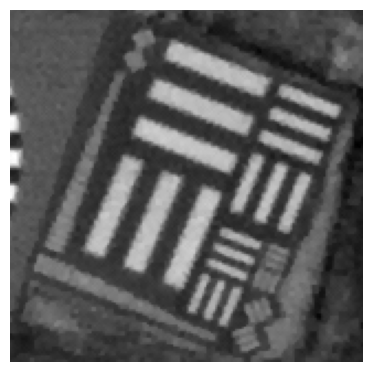

In [16]:
t1 = time.time()
shifts = ibp_py.calculate_shift(LR1, LRs, 'ecc')
SR_ibp = ibp_py.multi_frame_ibp(LRs, shifts, scale_factor=2, iterations=15, blur_sigma=1, tv_weight=0.5)
# SR_ibp = apply_richardson_lucy(SR_ibp, psf_size=5, iterations=30)
# SR_ibp = clahe(SR_ibp, clip_limit=0.5)
# SR_ibp = unsharp_mask(SR_ibp, radius=1.0, amount=1.2)

p_time = time.time() - t1
print(p_time)

Image.fromarray(SR_ibp).save('../HPO dataset/data2/SR_ibp.png')

sr_ibp = SR_ibp[x1:x1+48, y1:y1+48]
sr_ibp_window = SR_ibp[x2:x2+160, y2:y2+160]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_ibp_window, cmap='gray')

# ax2 = plt.subplot(1, 2, 2)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.imshow(sr_ibp, cmap='gray')

plt.show()

In [17]:
MTF_at_Nyquist_sr_ibp, MTF_50_sr_ibp = compute_mtf_at_nyquist(sr_ibp, filename = f'SR_IBP2', scale=1, dpi=100)

if MTF_at_Nyquist_sr_ibp is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_ibp)
    print("MTF_50:", MTF_50_sr_ibp)



print() 
metrics = calculate_metrics(HR[4:-4, 4:-4], SR_ibp[4:-4, 4:-4])
if metrics:
    print(f"PSNR: {metrics[0]:.2f} dB")
    print(f"SSIM: {metrics[1]:.4f}")

MTF evaluation finished! Elapsed time: 1.02 seconds
MTF_at_Nyquist: 2.2218555824108033
MTF_50: 0.13311233072729667

PSNR: 37.07 dB
SSIM: 0.9202


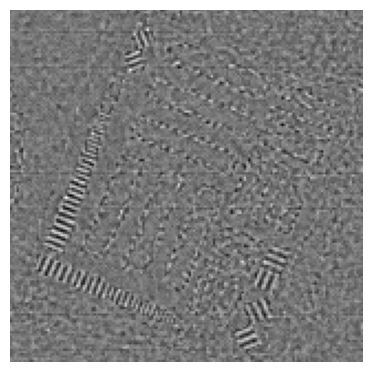

In [18]:
plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.axis('off')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(hr_window/255. - sr_ibp_window/255., cmap='gray')

# ax2 = plt.subplot(1, 2, 2)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.imshow(sr_ibp, cmap='gray')

plt.show()